# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

Covid-19 pandemic has wreaked havoc across the world. Entire world economy is at standstill. All the Sectors viz Manufacturing, Service, Information & Technology, Tourism, Food, Petroleum, Agriculture, Entertainment have been affected by it. Tourism is one such major contributor of the economy anywhere in the World. Post Covid-19 pandemic one major concern for any potential customer in Tourism sector will be as to the question whether the City I want to visit is safe or not? This project intends to map out the sprea regarding spread of Covid-19 as on 30.04.2020 in India and try to address this question. Domestic as well as International Tourism Companies shall be interested parties for the answer to the above question.

## Data <a name="data"></a>

Data for addressing the above problem will be downloaded from multiple sources:
+ Covid-19 Data for India: https://www.mygov.in/covid-19:
This is a government website which continuously updates the stats of Covid-19 spread in India. This data will give us an idea of State wise spread of the infection
+ Popular Tourist Destinations in India: https://traveltriangle.com/blog/places-to-visit-in-india-before-you-turn-30/ :
This data will give us popular tourist locations in India which we will be plotting on Map to get and comparing with Covid-19 spread to get an idea of which locations are safe to go 
+ Geojson file/Shape file for India for plotting Choropleth Map: https://github.com/datameet/maps/blob/master/Country/india-osm.geojson



In [1]:
import pandas as pd # library for data analsysis
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
!pip install descartes
!pip install geocoder
!pip install beautifulsoup4
!pip install lxml
!pip install geopandas
import urllib
import urllib.request
from bs4 import BeautifulSoup
import re
import descartes
import geopandas as gpd
import geocoder
from shapely.geometry import Point,Polygon
import folium # map rendering library
!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
%matplotlib inline
print('Libraries imported.')


     |████████████████████████████████| 102kB 2.9MB/s ta 0:00:011
     |████████████████████████████████| 92kB 6.4MB/s eta 0:00:011
     |████████████████████████████████| 829kB 6.5MB/s eta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built future
     |████████████████████████████████| 112kB 6.6MB/s eta 0:00:01
     |████████████████████████████████| 5.8MB 6.4MB/s eta 0:00:01     |████▋                           | 839kB 6.4MB/s eta 0:00:01     |████████████                    | 2.1MB 6.4MB/s eta 0:00:01     |███████████████████████████▉    | 5.0MB 6.4MB/s eta 0:00:01
     |████████████████████████████████| 931kB 7.8MB/s eta 0:00:01
     |████████████████████████████████| 1.8MB 9.2MB/s eta 0:00:01
     |████████████████████████████████| 14.7MB 5.9MB/s eta 0:00:011    |█████████████████▋              | 8.1MB 20.4MB/s eta 0:00:01     |████████████████████████        | 11.0MB 20.4MB/s eta 0:00:01

In [2]:
# specify which URL/web page we are going to be scraping
url = "https://www.mygov.in/covid-19"
# open the url using urllib.request and put the HTML into the page variable
page = urllib.request.urlopen(url)
# parse the HTML from our URL into the BeautifulSoup parse tree format
soup = BeautifulSoup(page, "html.parser")
# use the 'find_all' function to bring back all instances of the 'table' tag in the HTML and store in 'all_tables' variable
all_tables=soup.find_all("table")
right_table=soup.find('', class_='display')
A=[]
B=[]
C=[]
D=[]
E=[]
for row in right_table.findAll('tr'):
    cells=row.findAll('td')
    if len(cells)==5:
        A.append(cells[0].find(text=True))
        B.append(cells[1].find(text=True))
        C.append(cells[2].find(text=True))
        D.append(cells[3].find(text=True))
        E.append(cells[4].find(text=True))

df_states=pd.DataFrame(A,columns=['State/UTs'])
df_states['Confirmed']=B
df_states['Active']=C
df_states['Recovered']=D
df_states['Deceased']=E

locator = Nominatim(user_agent="myGeocoder")
from geopy.extra.rate_limiter import RateLimiter
# 1 - conveneint function to delay between geocoding calls
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
# 2- - create location column
df_states['location'] = df_states['State/UTs'].apply(geocode)
# 3 - create longitude, laatitude and altitude from location column (returns tuple)
df_states['point'] = df_states['location'].apply(lambda loc: tuple(loc.point) if loc else None)
# 4 - split point column into latitude, longitude and altitude columns
df_states[['latitude', 'longitude', 'altitude']] = pd.DataFrame(df_states['point'].tolist(), index=df_states.index)
df_states = df_states.drop(['location', 'point', 'altitude'], axis=1)
df_states["Confirmed"]=df_states["Confirmed"].astype(int, copy=True)
df_states["Active"]=df_states["Active"].astype(int, copy=True)
df_states["Recovered"]=df_states["Recovered"].astype(int, copy=True)
df_states["Deceased"]=df_states["Deceased"].astype(int, copy=True)
df_states.head()

,State/UTs,Confirmed,Active,Recovered,Deceased,latitude,longitude
0,Andaman and Nicobar,33,17,16,0,7.000017,93.811082
1,Andhra Pradesh,1525,1051,441,33,15.924091,80.186381
2,Arunachal Pradesh,1,0,1,0,27.689171,96.459723
3,Assam,43,10,32,1,26.407384,93.255130
4,Bihar,471,370,98,3,25.644085,85.906508


In [3]:
df_states.rename(columns = {'State/UTs':'States'}, inplace = True)
df_states.head()

,States,Confirmed,Active,Recovered,Deceased,latitude,longitude
0,Andaman and Nicobar,33,17,16,0,7.000017,93.811082
1,Andhra Pradesh,1525,1051,441,33,15.924091,80.186381
2,Arunachal Pradesh,1,0,1,0,27.689171,96.459723
3,Assam,43,10,32,1,26.407384,93.255130
4,Bihar,471,370,98,3,25.644085,85.906508


In [4]:
filename ="Tourism_India_3.csv"
df = pd.read_csv(filename)
Place = df[['Place']].copy()
locator = Nominatim(user_agent="myGeocoder")
from geopy.extra.rate_limiter import RateLimiter

# 1 - conveneint function to delay between geocoding calls
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
# 2- - create location column
df['location'] = df['Place'].apply(geocode)
# 3 - create longitude, laatitude and altitude from location column (returns tuple)
df['point'] = df['location'].apply(lambda loc: tuple(loc.point) if loc else None)
# 4 - split point column into latitude, longitude and altitude columns
df[['latitude', 'longitude', 'altitude']] = pd.DataFrame(df['point'].tolist(), index=df.index)

df_tourism=df.copy()
df_tourism=df_tourism.drop(['location', 'point', 'altitude'], axis=1)
df_tourism=df_tourism.dropna()
df_tourism=df_tourism.drop(['USP'], axis=1)
df_tourism.rename(columns = {'Place':'States'}, inplace = True)
df_tourism.head()

,States,latitude,longitude
0,Goa,15.300454,74.085513
1,Srinagar,34.074744,74.820444
2,Andaman,10.000105,93.000019
3,Leh-Ladakh,34.164203,77.584813
4,Kerala,10.352874,76.512040


In [5]:
df_combined=df_states.append(df_tourism, ignore_index = True)
df_combined

,States,Confirmed,Active,Recovered,Deceased,latitude,longitude
0,Andaman and Nicobar,33.0,17.0,16.0,0.0,7.000017,93.811082
1,Andhra Pradesh,1525.0,1051.0,441.0,33.0,15.924091,80.186381
2,Arunachal Pradesh,1.0,0.0,1.0,0.0,27.689171,96.459723
3,Assam,43.0,10.0,32.0,1.0,26.407384,93.255130
4,Bihar,471.0,370.0,98.0,3.0,25.644085,85.906508
5,Chandigarh,88.0,71.0,17.0,0.0,30.719402,76.764655
6,Chhattisgarh,43.0,7.0,36.0,0.0,21.663736,81.840635
7,Delhi,3738.0,2510.0,1167.0,61.0,28.651718,77.221939
8,Goa,7.0,0.0,7.0,0.0,15.300454,74.085513
9,Gujarat,4721.0,3750.0,735.0,236.0,22.415408,72.031497


In [6]:
df_combined= df_combined.fillna(0)
df_combined

,States,Confirmed,Active,Recovered,Deceased,latitude,longitude
0,Andaman and Nicobar,33.0,17.0,16.0,0.0,7.000017,93.811082
1,Andhra Pradesh,1525.0,1051.0,441.0,33.0,15.924091,80.186381
2,Arunachal Pradesh,1.0,0.0,1.0,0.0,27.689171,96.459723
3,Assam,43.0,10.0,32.0,1.0,26.407384,93.255130
4,Bihar,471.0,370.0,98.0,3.0,25.644085,85.906508
5,Chandigarh,88.0,71.0,17.0,0.0,30.719402,76.764655
6,Chhattisgarh,43.0,7.0,36.0,0.0,21.663736,81.840635
7,Delhi,3738.0,2510.0,1167.0,61.0,28.651718,77.221939
8,Goa,7.0,0.0,7.0,0.0,15.300454,74.085513
9,Gujarat,4721.0,3750.0,735.0,236.0,22.415408,72.031497


## Methodology <a name="methodology"></a>

Now that we have collected data from different data sources:
+ First we will be combining the data and plot it on Map of India.This will superimpose Tourist Locations (Green) & Active Covid-19 infected locations (Red) throughout India.We can visually pinpoint the location which will be safe to visit
+ In the second step we will collect the data for shortlisted location using FourSquare
+ Third step will involve analysis and clustering of the data for the shortlisted venue. We will present map of all tourist locations and also create clusters (using k-means clustering) of those locations to identify general zones / neighborhoods / addresses

In [7]:
crs={'init':'epsg:4326'}
geometry=[Point (xy) for xy in zip(df_combined["longitude"],df_combined["latitude"])]
geometry[:3]

In [8]:
geo_df=gpd.GeoDataFrame(df_combined,crs=crs,geometry=geometry)
geo_df.shape

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


(37, 8)

Text(0.5, 1, 'Tourism post Covid-19 in India')

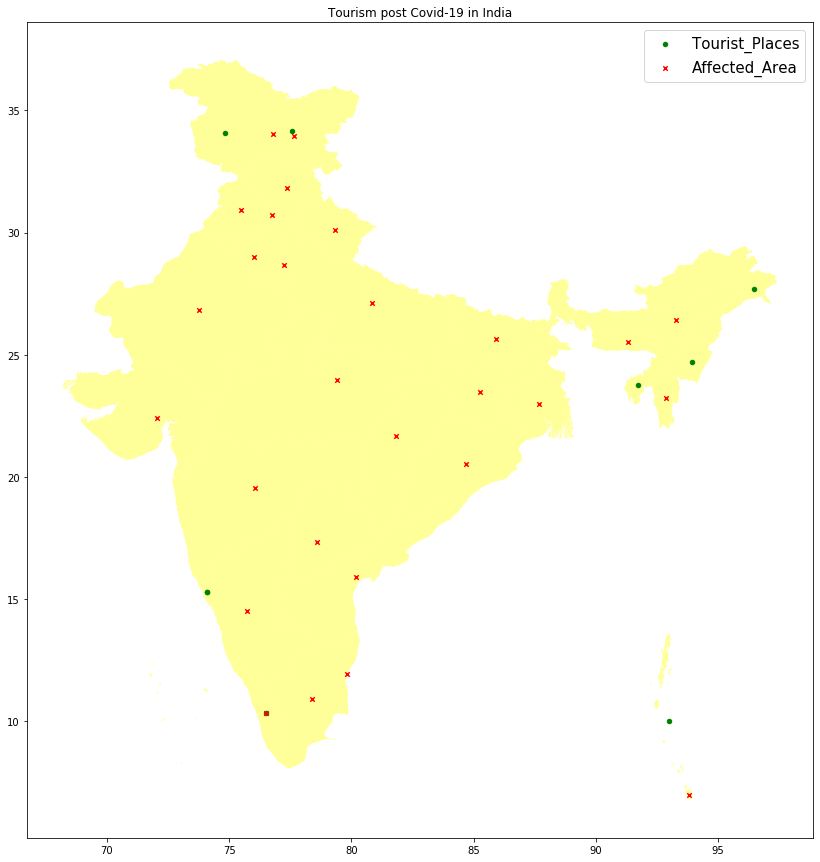

In [20]:
fp = "Indian_States.shp"
map_df = gpd.read_file(fp)
fig,ax=plt.subplots(figsize=(15,15))
map_df.plot(ax=ax,alpha=0.4,color="Yellow")
geo_df[geo_df['Active']==0].plot(ax=ax,markersize=20,color="green",marker="o",label="Tourist_Places")
geo_df[geo_df['Active']!=0].plot(ax=ax,markersize=20,color="red",marker="x",label="Affected_Area")
plt.legend(prop={'size':15})
plt.title('Tourism post Covid-19 in India')

Thus out of the five shortlisted hot tourist destinations in India viz:
+ Goa
+ Andaman & Nicobar Islands
+ Srinagar
+ Leh-Ladakh
+ Kerela

We see that only Goa is the place which has no active infection in its vicinity.Let us explore Goa using Foursqaure

In [55]:
filename ="Goa.csv"
df_goa= pd.read_csv(filename)
df_goa.head()

,Tourist_Attraction,USP
0,Aguada Fort,Beautiful Ambiance
1,Chapora Fort,For Selfie Lovers
2,Terekhol Fort,Serene Ambiance
3,Reis Mogos Fort,For History Lovers
4,Cabo De Rama Fort,Mythological Site


In [57]:
locator = Nominatim(user_agent="myGeocoder")
from geopy.extra.rate_limiter import RateLimiter
# 1 - conveneint function to delay between geocoding calls
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
# 2- - create location column
df_goa['location'] = df_goa['Tourist_Attraction'].apply(geocode)
# 3 - create longitude, laatitude and altitude from location column (returns tuple)
df_goa['point'] = df_goa['location'].apply(lambda loc: tuple(loc.point) if loc else None)
# 4 - split point column into latitude, longitude and altitude columns
df_goa[['latitude', 'longitude', 'altitude']] = pd.DataFrame(df_goa['point'].tolist(), index=df_goa.index)
df_goa = df_goa.drop(['location', 'point', 'altitude'], axis=1)
df_goa.head()

,Tourist_Attraction,USP,latitude,longitude
0,Aguada Fort,Beautiful Ambiance,15.492328,73.773204
1,Chapora Fort,For Selfie Lovers,15.603370,73.737162
2,Terekhol Fort,Serene Ambiance,15.721476,73.686472
3,Reis Mogos Fort,For History Lovers,NaN,NaN
4,Cabo De Rama Fort,Mythological Site,15.087411,73.919927


## Analysis <a name="analysis"></a>

Let's perform some basic explanatory data analysis and derive some additional info from our raw data. First let's get geo co-ordinates of each tourist attraction

In [60]:
df_goa=df_goa.dropna() #Dropping the rows whose co-ordinates could not be fetched
df_goa.shape
df_goa

,Tourist_Attraction,USP,latitude,longitude
0,Aguada Fort,Beautiful Ambiance,15.492328,73.773204
1,Chapora Fort,For Selfie Lovers,15.603370,73.737162
2,Terekhol Fort,Serene Ambiance,15.721476,73.686472
4,Cabo De Rama Fort,Mythological Site,15.087411,73.919927
6,Bom Jesus Basilica,Baroque Architecture,15.500678,73.911052
7,Se Cathedral,Largest Asian Church,15.503783,73.912274
8,Church Of St. Francis Of Assisi,World’s 2nd Largest Bell,40.748835,-73.990558
9,Church Of St. Cajetan,Stunning White Structure,15.505774,73.915219
10,Thalassa Restaurant,Epicurean’s Delight,42.856251,3.036712
11,The Fisherman’s Wharf,For Seafood Lovers,36.604575,-121.892642


In [62]:
#Double checking whether location data for Goa is correct
address = 'Goa,India'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude_goa = location.latitude
longitude_goa= location.longitude
print('The geograpical coordinates of Goa are {}, {}.'.format(latitude_goa, longitude_goa))

The geograpical coordinates of Goa are 15.3004543, 74.0855134.


In [69]:
# create map of Goa using latitude and longitude values
map_goa = folium.Map(location=[latitude_goa, longitude_goa], zoom_start=9)

# add markers to map
for lat, lng, Tourist_Attraction in zip(df_goa['latitude'], df_goa['longitude'], df_goa['Tourist_Attraction']):
    label = '{}'.format(Tourist_Attraction)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_goa)
map_goa

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

#### Define Foursquare Credentials and Version

In [71]:
CLIENT_ID = 'KGMEMETKH2CRDESEOD5Q2NXFUYEKWH4BAOSFXOAFGZ03ZQP1' # your Foursquare ID
CLIENT_SECRET = 'OWFMRPYLBQGWUZ2ZUXVZKIVY4SIKFDV4WIP0VZG5BQ0KYL15' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: KGMEMETKH2CRDESEOD5Q2NXFUYEKWH4BAOSFXOAFGZ03ZQP1
CLIENT_SECRET:OWFMRPYLBQGWUZ2ZUXVZKIVY4SIKFDV4WIP0VZG5BQ0KYL15


#### Let's explore the first tourist location in our dataframe.

Get the neighborhood's name.

In [72]:
df_goa.loc[0, 'Tourist_Attraction']

'Aguada Fort'

Get the attraction's latitude and longitude values

In [74]:
place_latitude = df_goa.loc[0, 'latitude'] # neighborhood latitude value
place_longitude= df_goa.loc[0, 'longitude'] # neighborhood longitude value
place_name = df_goa.loc[0, 'Tourist_Attraction'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(place_name, 
                                                               place_latitude, 
                                                               place_longitude))

Latitude and longitude values of Aguada Fort are 15.49232845, 73.77320439349222.


#### Now, let's get the top 100 venues that are near Fort Aguada within a radius of 500 meters.

In [84]:
# type your answer here
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    place_latitude, 
    place_longitude, 
    radius, 
    LIMIT)
url # display URL


'https://api.foursquare.com/v2/venues/explore?&client_id=KGMEMETKH2CRDESEOD5Q2NXFUYEKWH4BAOSFXOAFGZ03ZQP1&client_secret=OWFMRPYLBQGWUZ2ZUXVZKIVY4SIKFDV4WIP0VZG5BQ0KYL15&v=20180605&ll=15.49232845,73.77320439349222&radius=500&limit=100'

In [85]:
import requests # library to handle requests
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5eae969ca2e538001b531a76'},
 'response': {'headerLocation': 'Candolim',
  'headerFullLocation': 'Candolim',
  'headerLocationGranularity': 'city',
  'totalResults': 4,
  'suggestedBounds': {'ne': {'lat': 15.496828454500005,
    'lng': 73.77786534596194},
   'sw': {'lat': 15.487828445499996, 'lng': 73.7685434410225}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4f1aae96e4b0d79041d29e93',
       'name': 'Aguada Lighthouse',
       'location': {'lat': 15.493268440435177,
        'lng': 73.77453451587759,
        'labeledLatLngs': [{'label': 'display',
          'lat': 15.493268440435177,
          'lng': 73.77453451587759}],
        'distance': 176,
        'cc': 'IN',
        'country': 'India',
        'formattedAddress': ['India']

Defining the **get_category_type** function

In [86]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a *pandas* dataframe.

In [87]:
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  after removing the cwd from sys.path.


,name,categories,lat,lng
0,Aguada Lighthouse,Lighthouse,15.493268,73.774535
1,New Aguada Lighthouse,Lighthouse,15.491995,73.772622
2,Marbella Guest House,Hotel,15.495570,73.770886
3,Bougainvillea Guest House,Motel,15.495981,73.771357


In [89]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

4 venues were returned by Foursquare.


## Explore Tourist Attractions in Goa

#### Let's create a function to repeat the same process to all the tourist attractions in Goa

In [91]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [92]:
goa_venues = getNearbyVenues(names=df_goa['Tourist_Attraction'],
                                   latitudes=df_goa['latitude'],
                                   longitudes=df_goa['longitude']
                                  )

Aguada Fort
Chapora Fort
Terekhol Fort
Cabo De Rama Fort
Bom Jesus Basilica
Se Cathedral
Church Of St. Francis Of Assisi
Church Of St. Cajetan
Thalassa Restaurant
The Fisherman’s Wharf
Tito’s Club
Mambo’s
Britto’s
Cotigao Wildlife Sanctuary
Bondla Wildlife Sanctuary
Mapusa Market
Saturday Night Market
Anjuna Flea Market
Aguada Beach
Arambol Beach
Baga Beach
Anjuna Beach
Butterfly Beach
Calangute Beach
Colva Beach
Cansaulim Beach
Benaulim Beach
Dona Paula Beach
Ashvem Beach
Mobor Beach
Sinquerim Beach
Querim Beach
Chorao Island
Divar Island
Grand Island
Archives Museum
Panaji
Dudhsagar Waterfalls
Shri Shantadurga Temple
Candolim Beach
Tito’s Street
Palolem Beach
Casino Cruise
The Church Of Our Lady Of Immaculate Conception
Club Cubana
Arvalem Waterfall


In [93]:
print(goa_venues.shape)
goa_venues.head()

(770, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Aguada Fort,15.492328,73.773204,Aguada Lighthouse,15.493268,73.774535,Lighthouse
1,Aguada Fort,15.492328,73.773204,New Aguada Lighthouse,15.491995,73.772622,Lighthouse
2,Aguada Fort,15.492328,73.773204,Marbella Guest House,15.495570,73.770886,Hotel
3,Aguada Fort,15.492328,73.773204,Bougainvillea Guest House,15.495981,73.771357,Motel
4,Chapora Fort,15.603370,73.737162,Chapora Fort,15.603660,73.736767,Historic Site


Let's check how many venues were returned for each neighborhood

In [94]:
goa_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Aguada Beach,20,20,20,20,20,20
Aguada Fort,4,4,4,4,4,4
Anjuna Beach,15,15,15,15,15,15
Anjuna Flea Market,17,17,17,17,17,17
Arambol Beach,28,28,28,28,28,28
Archives Museum,39,39,39,39,39,39
Arvalem Waterfall,2,2,2,2,2,2
Ashvem Beach,18,18,18,18,18,18
Baga Beach,29,29,29,29,29,29


#### Let's find out how many unique categories can be curated from all the returned venues

In [95]:
print('There are {} uniques categories.'.format(len(goa_venues['Venue Category'].unique())))

There are 165 uniques categories.


## Analyze Each Neighborhood

In [96]:
# one hot encoding
goa_onehot = pd.get_dummies(goa_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
goa_onehot['Neighborhood'] = goa_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [goa_onehot.columns[-1]] + list(goa_onehot.columns[:-1])
goa_onehot = goa_onehot[fixed_columns]

goa_onehot.head()

,Neighborhood,Accessories Store,American Restaurant,Antique Shop,Art Museum,Asian Restaurant,BBQ Joint,Bakery,Bank,Bar,...,Theater,Tourist Information Center,Trade School,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Whisky Bar,Wine Shop,Yoga Studio
0,Aguada Fort,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Aguada Fort,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Aguada Fort,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Aguada Fort,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Chapora Fort,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


And let's examine the new dataframe size.

In [97]:
goa_onehot.shape

(770, 166)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [99]:
goa_grouped = goa_onehot.groupby('Neighborhood').mean().reset_index()
goa_grouped

,Neighborhood,Accessories Store,American Restaurant,Antique Shop,Art Museum,Asian Restaurant,BBQ Joint,Bakery,Bank,Bar,...,Theater,Tourist Information Center,Trade School,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Whisky Bar,Wine Shop,Yoga Studio
0,Aguada Beach,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000
1,Aguada Fort,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Anjuna Beach,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Anjuna Flea Market,0.000000,0.000000,0.0000,0.000000,0.058824,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Arambol Beach,0.000000,0.000000,0.0000,0.000000,0.071429,0.000000,0.000000,0.000000,0.035714,...,0.035714,0.000000,0.000000,0.000000,0.035714,0.000000,0.000000,0.000000,0.000000,0.000000
5,Archives Museum,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.025641,0.000000,0.000000,0.000000,0.000000,0.025641,0.025641,0.000000
6,Arvalem Waterfall,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,Ashvem Beach,0.000000,0.000000,0.0000,0.000000,0.055556,0.000000,0.000000,0.000000,0.055556,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,Baga Beach,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Benaulim Beach,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [100]:
goa_grouped.shape

(39, 166)

#### Let's print each neighborhood along with the top 5 most common venues

In [138]:
num_top_venues = 5

for hood in goa_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = goa_grouped[goa_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Aguada Beach----
                  venue  freq
0            Restaurant  0.15
1    Italian Restaurant  0.10
2                 Hotel  0.10
3     Indian Restaurant  0.05
4  Caribbean Restaurant  0.05


----Aguada Fort----
                venue  freq
0          Lighthouse  0.50
1               Motel  0.25
2               Hotel  0.25
3       Movie Theater  0.00
4  Mughlai Restaurant  0.00


----Anjuna Beach----
                  venue  freq
0                  Café  0.33
1     Indian Restaurant  0.13
2                 Beach  0.13
3  Fast Food Restaurant  0.07
4           Flea Market  0.07


----Anjuna Flea Market----
                venue  freq
0                Café  0.24
1          Restaurant  0.12
2           Nightclub  0.12
3   Indian Restaurant  0.06
4  Seafood Restaurant  0.06


----Arambol Beach----
               venue  freq
0  Indian Restaurant  0.32
1             Resort  0.18
2         Restaurant  0.11
3   Asian Restaurant  0.07
4    Goan Restaurant  0.07


----Archives Museum--

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [139]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [169]:
import numpy as np # library to handle data in a vectorized manner
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = goa_grouped['Neighborhood']

for ind in np.arange(goa_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(goa_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aguada Beach,Restaurant,Hotel,Italian Restaurant,Yoga Studio,Spa,Bar,Beach,Caribbean Restaurant,Historic Site,Hotel Pool
1,Aguada Fort,Lighthouse,Hotel,Motel,Yoga Studio,Dumpling Restaurant,Fish & Chips Shop,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Electronics Store
2,Anjuna Beach,Café,Indian Restaurant,Beach,Rest Area,Flea Market,Seafood Restaurant,Snack Place,Restaurant,Fast Food Restaurant,Discount Store
3,Anjuna Flea Market,Café,Nightclub,Restaurant,Indian Restaurant,Juice Bar,Fast Food Restaurant,Seafood Restaurant,Modern European Restaurant,Flea Market,Bed & Breakfast
4,Arambol Beach,Indian Restaurant,Resort,Restaurant,Asian Restaurant,Goan Restaurant,Breakfast Spot,Hostel,Vegetarian / Vegan Restaurant,Café,Theater


## Cluster Neighborhoods

Run *k*-means to cluster the neighborhood into 5 clusters.

In [170]:
# import k-means from clustering stage
from sklearn.cluster import KMeans
# set number of clusters
kclusters = 5

goa_grouped_clustering = goa_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(goa_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 3, 2, 2, 2, 2, 1, 2, 2, 1], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [171]:
df_goa.rename(columns = {'Tourist_Attraction':'Neighborhood'}, inplace = True)
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

goa_merged = df_goa

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
goa_merged = goa_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
goa_merged=goa_merged.dropna()
goa_merged["Cluster Labels"]=goa_merged["Cluster Labels"].astype(int)
goa_merged.head() # check the last columns!

,Neighborhood,USP,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aguada Fort,Beautiful Ambiance,15.492328,73.773204,3,Lighthouse,Hotel,Motel,Yoga Studio,Dumpling Restaurant,Fish & Chips Shop,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Electronics Store
1,Chapora Fort,For Selfie Lovers,15.603370,73.737162,2,Indian Restaurant,Restaurant,Lounge,Mountain,Mediterranean Restaurant,Asian Restaurant,Historic Site,Resort,Rest Area,Dumpling Restaurant
2,Terekhol Fort,Serene Ambiance,15.721476,73.686472,2,Resort,Historic Site,Harbor / Marina,Diner,Yoga Studio,Donut Shop,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Electronics Store
4,Cabo De Rama Fort,Mythological Site,15.087411,73.919927,4,Scenic Lookout,Bar,Yoga Studio,Drugstore,Fish & Chips Shop,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Electronics Store,Eastern European Restaurant
6,Bom Jesus Basilica,Baroque Architecture,15.500678,73.911052,0,Ice Cream Shop,Vegetarian / Vegan Restaurant,History Museum,Historic Site,Donut Shop,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Electronics Store,Eastern European Restaurant


Finally, let's visualize the resulting clusters

In [178]:
# create map
map_clusters = folium.Map(location=[latitude_goa, longitude_goa], zoom_start=8)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(goa_merged['latitude'], goa_merged['longitude'], goa_merged['Neighborhood'], goa_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Results and Discussion <a name="results"></a>

Our Analysis shows that India is not an exception as far as Covid-19 spread is concerned.The virus has spread far and wide in the Country just like the Rest of the world.In India,despite its geographical area, "Goa" remains the only State/Tourist location which is safe to visit as of 02.05.2020. Goa despite being a small state has a lot to offer to Domestic as well as International tourists. There are multiple forts.Also there a number of beaches as the state is located along the Arabian Sea.It justifies its USP viz "Official Party Hub"

## Conclusion <a name="conclusion"></a>

The purpose of this project was to identify tourist destinations in India which would be safe to visit post normalization of Covid-19 pandemic in order to aid stakeholders (Domestic & International Tour operators) in offering customized targeted packages to prospective customers. By calculating and clustering the top venues for each Tourist Destination in Goa we were able to provide ample options to the prospective customer for planning his trip.Clustering of those locations was then performed in order to create major zones of interesting places to visit